## PyTorch Neural network Classification
### What is a classification problem?
A **classification problem** involves predicting whhether something is one thing or another.

Some Types of classification:
* **Binary classification** - target can be one of two options. Yes or No
* **Multi-class classification** - targer can be one of more than two options.
* **Multi-label classification** - target can be assigned more than one option.

#### 0. Architecture of a classification neural network

#### 1. Getting binary classification data ready

We'll use the `make_circles()` method from scikit-learn to generate two circles with different coloured dots.

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
print(f'First 5 X features: \n{X[:5]}')
print(f'\nFirst 5 y labels:\n{y[:5]}')

First 5 X features: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


Each pair of `X` feature has a `y` label value of either 0 or 1.

This tells us that our problem is **binary classification** since there's only two options.

how many vlaues of each class is there?

In [4]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

This means that there are 500 each.

We will now visualize it.

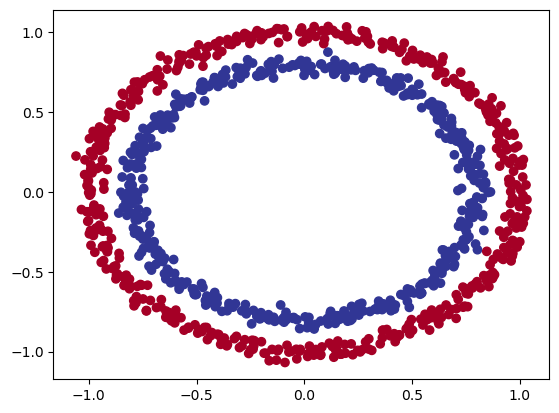

In [5]:
# Visualize with a py plot

import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
           y=X[:, 1],
           c=y,
           cmap=plt.cm.RdYlBu)

##### 1.1 Input and output shapes

one of the most common errors in deep learning is **shape errors**.

Mismatching the shapes of tensors and tensor operations will result in errors in your models.

In [6]:
# Checking the shape of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

This tell us the second dimension of `X` means it has two features (vector) where as `y` has a single feature (scalar)

Which means it has two input and one output.

##### 1.2 Turn data into tensors and create train and test splits

We first need to do the following:
1. Turn our data into tensors.
2. Split our data into training and test sets.

In [7]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
# Split data into train and test sets using scikit train_test_split()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducable

# Print the length
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

#### 2. Building a model

Data is ready, time to build a model.

Break it down into few parts.
1. Setting up device agnostic code
2. Constructing a model by subclassing.
3. Defining a loss function and optimizer.
4. Creating a training loop



In [9]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

This setup we will be referred as **supervised learning**.

Create a model with the following:
1. Subclass `nn.Module`
2. Creates 2 `nn.Linear` layers
3. Define a `forward()` method
4. Initialize the model to target device

In [10]:
# 1. Construct a model class that subclass

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create nn.Linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # 2 input, 5 outputs
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # 5 input, 1 output
    
    # 3. Define forward() method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # return the output of layer_2
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

Why do we need to have to turn 2 features into 5 features in the hidden layer?

This allows the model to learn patterns from 5 numbers rather than just 2 number, *potentially* leading to better outputs. This is not always the cause

The number of hidden units you can use in neural network layers is a **hyperparameter** (a value we can set by ourselves) and there's no set in stone value you have to use.

Generally more is better but there's also such thing as too much. The amount you choose will depend on your model type and dataset you're working with.

You can also utilize `nn.Sequential`. It performs a forward pass computation of the input data through the layers in the order they appear.



In [11]:
# Replicate CircleModelV0 with nn.Sequential
model_0_replicate = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

`nn.Sequential` is good for straight-forward computations, however, it always runs in sequential. If you want something else to happen, like not straight-forward sequential computation. You'l want to define your own custom `nn.Module` subclass.

Now we have the model. we can pass data into it.

In [12]:
# Make predictions with the model
print(X_test.shape)
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

torch.Size([200, 2])
Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.5072],
        [-0.3901],
        [-0.4462],
        [-0.5259],
        [ 0.1374],
        [ 0.2043],
        [ 0.0712],
        [ 0.2119],
        [-0.4709],
        [-0.3758]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


##### 2.1 Setup loss function and optimizer
Setup a loss (also called as criterion or cost function) and optimizer.

Different problems types require different loss function.

We will be using `binary cross entropy loss` since the problem is a binary classification.

PyTorch has two binary cross implementations:
1. `torch.nn.BCELoss()` - creates a loss func that measures the binary cross entropy between the target (label) and input (features).
2. `torch.nn.BCEWithLogitsLoss()` - It is the same with the above but it has a sigmoidd layer (`nn.Sigmoid`) built-in.

We will be using `torch.nn.BCEWithLogitsLoss()` since it states in the documentation that it is a better option because it's more numerically stable.

For the optimizer we'll use `torch.optim.SGD()` to optimize the model with a learning rate of 0.1.

In [13]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

We need to create an **evaluation metric**

If loss measures how wrong. Evaluation metrics measures how right.

There are several evaluation metrics that can be used for classification problem but let's start with **accuracy**.

In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred))
    return acc

#### 3. Train model


##### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediciton labels)

 The raw outputs are often referred to as `logits`. It is the outpus of a neural network before the activation function is applied.

 However, logits are hard to interperet. we' liked some numbers that are comparable to our truth tables. To get our model's raw output (logits) into such form we can use `sigmoid activation function`. 

 Using **sigmoid activation function** will get the form of `prediction probabilities`. Since it is binary classification our ideal outputs are 0 or 1.

 The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1

 More specifically:
* If `y_preds_probs` >= 0.5, `y=1` (class 1)
* If `y_preds_probs` <= 0.5, `y=0` (class 0)

To turn our prediction probabilities in `prediction labels`, we can round the outputs of the **sigmoid activation function**.

In [15]:
# View the first 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
print('y_logits', y_logits)

y_logits tensor([[-0.5072],
        [-0.3901],
        [-0.4462],
        [-0.5259],
        [ 0.1374]], device='cuda:0', grad_fn=<SliceBackward0>)


In [16]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
print('y_pred_probs', torch.sigmoid(y_logits))

y_pred_probs tensor([[0.3759],
        [0.4037],
        [0.3903],
        [0.3715],
        [0.5343]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [17]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# Get rid of extra dimension
y_preds.squeeze()

tensor([0., 0., 0., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

**Note:** The use of *sigmoid activation function* is often only for binary classification logits. For multi-class classification, we'll be looking at using the *softmax activation*. The use of sigmoid activation function is not requred when passing our model's raw output to the `nn.BCEWithLogitsLoss` (the "logits") in logits loss is because it works on the model's raw logits output), this is becuase it has a sigmoid function built-in.

##### 3.2 Building a training and testing loop

In [18]:
# Set manual seed for replicability
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evalulation loop
for epoch in range(epochs):
    ## Set to trainig mode
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train) # loss_fn has built-in activation function
    acc =accuracy_fn(y_true=y_train, y_pred=y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ## set to testing/eval
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print data every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71045, Accuracy: 0.49% | Test loss: 0.70929, Test acc: 0.45%
Epoch: 10 | Loss: 0.70382, Accuracy: 0.50% | Test loss: 0.70317, Test acc: 0.45%
Epoch: 20 | Loss: 0.70014, Accuracy: 0.50% | Test loss: 0.69981, Test acc: 0.47%
Epoch: 30 | Loss: 0.69792, Accuracy: 0.50% | Test loss: 0.69780, Test acc: 0.46%
Epoch: 40 | Loss: 0.69650, Accuracy: 0.50% | Test loss: 0.69652, Test acc: 0.47%
Epoch: 50 | Loss: 0.69555, Accuracy: 0.50% | Test loss: 0.69566, Test acc: 0.48%
Epoch: 60 | Loss: 0.69488, Accuracy: 0.50% | Test loss: 0.69508, Test acc: 0.49%
Epoch: 70 | Loss: 0.69441, Accuracy: 0.50% | Test loss: 0.69466, Test acc: 0.49%
Epoch: 80 | Loss: 0.69406, Accuracy: 0.50% | Test loss: 0.69437, Test acc: 0.51%
Epoch: 90 | Loss: 0.69381, Accuracy: 0.50% | Test loss: 0.69416, Test acc: 0.52%


Basd on the performance of our model. It wen through the training and testing stesps fine but the results did not move too much..

The accuracy barely moves above 50% because we are working with a balanced binary classification problem, it means our model is performing as good as randomg guessing.

#### 4. Make predictions and evaluate the model
It look like the model is *random guessing*.

In orderto evaluate the model performance. **Visualization** is key. By plotting our model's prediction, the data is trying to predict on and the decision boundary it's creating for whether something is class 0 or 1.

To do so we need to code to download and import the `helper_functions.py` script from [Learn Pytorch for Deep Learning repo](https://github.com/mrdbourke/pytorch-deep-learning)

We need to also import `plot_predictions()` which we wrote in notebook 01 to use later.

In [19]:
import requests
from pathlib import Path

# Download helper function
if Path("utils/helper_function.py").is_file():
    print("helper function exists")
else:
    print("Downloading helper_function.py")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open("utils/helper_functions.py", 'wb') as f:
        f.write(request.content)

from utils.helper_functions import plot_predictions, plot_decision_boundary

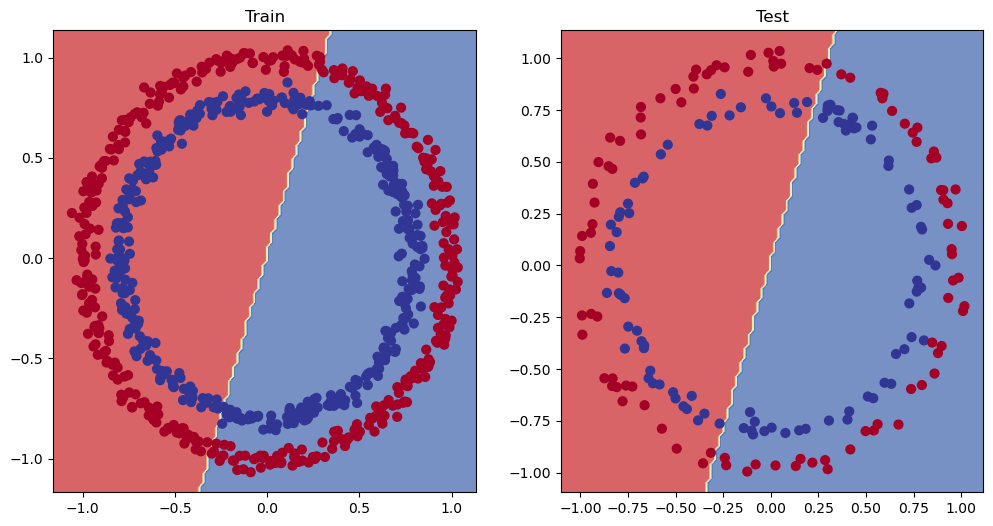

In [20]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

Based on the visualization, the cause of the model's performance issue is that it is currently trying to split the red and blue dots using a straight line.

This explains the 50% accuracy. Since our data is circular, drawing a stragiht line can at best cut it down in the middle.

In machine learning termos, our model is **underfitting**, meaning it's not learning predictive patterns from the data.

So how do we improve this?

#### 5. Improving a model (from a model perspective)

We will be fixing our model's underfitting problem.

Focussing specifically on the model (not the data), there are few ways we could do this.
* `Adding more layers`- increasing the layers will potentially increase the learning capabilities of the model. More layer is often referes to as making your neural network deeper.
* `Add more hidden units` - Similar to the above, increasing the hidden units per layer will potentially increase the learning capabilities of the model, more hidden unit is often referred to as making your neural network wider.
* `Fitting for longer (more epochs)` - Your model might learn more if it had more opportunities to look at the data.
* `Changing the activation functions` - Try using other activation functions such as non-linear functions.
* `Change the learning rate` - The learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.
* `Change the loss function` - Different problems requires different loss function. Try using other loss function for the model.
* `Use transfer learning` - Take a pretrained model from a problem domain similar to yours and adjust it to your own problem.

**Note**: Becuase you can adjust all of these by hand, they are referrred to as **hyperparameters**.

Let's try by adding more layers to your model, fit for longer (`epochs=1000` instead of `epochs=100`) and increase the number of hidden units from 5 to 10.

In [21]:
# Creating a new model version
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1()
model_1 = model_1.to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
# Create loss func and optimizer instance

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [23]:
# Set manual seed for replicability
torch.manual_seed(42)

# Set epoch
epochs = 1000

# Set data to device
X_test, y_test = X_test.to(device), y_test.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)

# Creating test/train loop
for epoch in range(epochs):
    # Set train mode
    model_1.train()

    # Set forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss/accuraacy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer
    optimizer.zero_grad()

    # Loss backward
    loss.backward

    # Optimizer step
    optimizer.step()

    # Test mode
    model_1.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # Calculate loss/acc
        test_loss = loss_fn(y_logits, y_train)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out model logs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%


Epoch: 100 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%
Epoch: 200 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%
Epoch: 300 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%
Epoch: 400 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%
Epoch: 500 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%
Epoch: 600 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%
Epoch: 700 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%
Epoch: 800 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%
Epoch: 900 | Loss: 0.69396, Accuracy: 0.51% | Test loss: 0.69396, Test acc: 0.51%


Diagnostics on the model's log shows that the model was not able to learn with more a wider and deeper NN. It looks like it didn't learn any patterns

We will try visualizing the logs.

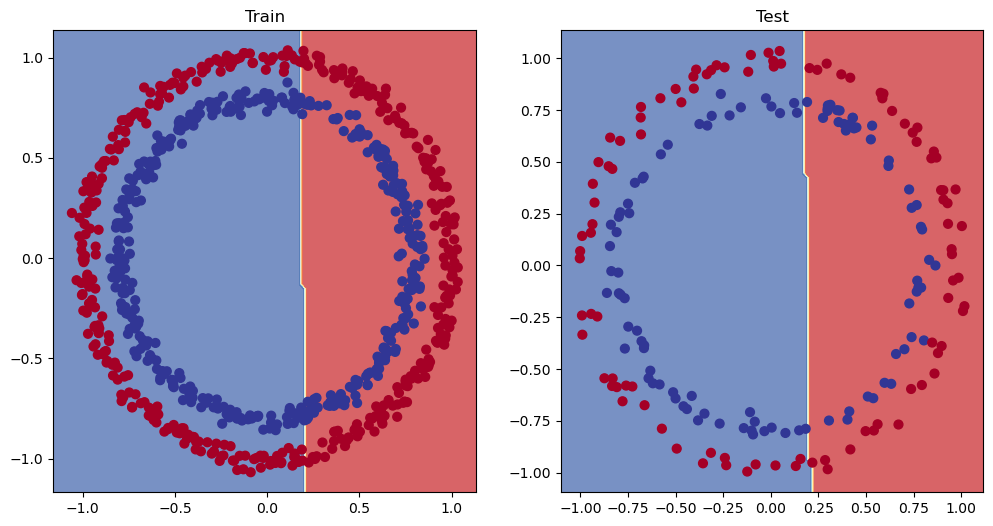

In [24]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

##### 5.1 Preparing data to see if our model can model a straight line

We will be creating a linear data to see if our model is able to predict it.

In [25]:
# Create some data
weight = 0.6
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start=start, end=end, step=step, device=device).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]], device='cuda:0'),
 tensor([[0.3000],
         [0.3060],
         [0.3120],
         [0.3180],
         [0.3240]], device='cuda:0'))

In [26]:
# Split data into train and test data
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check leng of train and test data
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

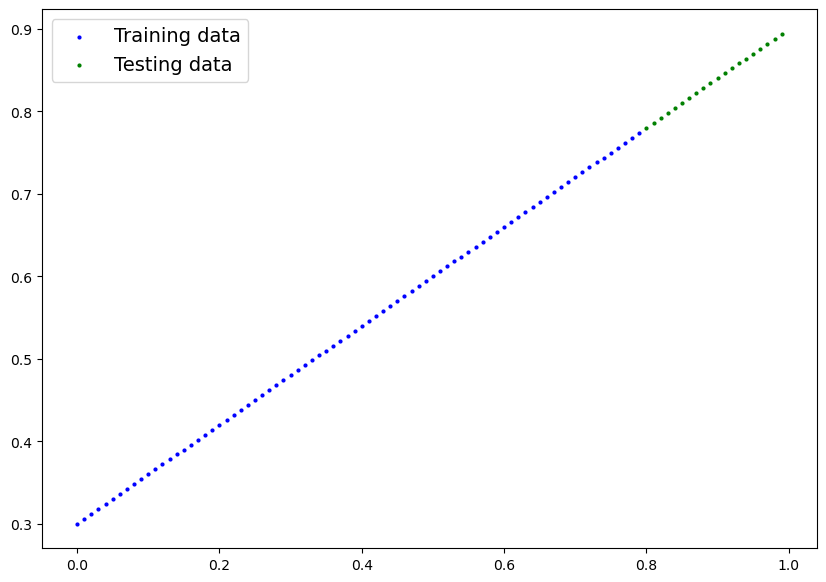

In [27]:
# Create plotting for linear data
plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(), test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu())

##### Adjusting `model_1` to fight a straight line

In [28]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
# Setup Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.01)

In [30]:
# Train model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

for epoch in range(epochs):
    ## Training
    model_2.train()

    # 1. Forward pass
    pred = model_2(X_train_regression)

    # 2. Calculate loss
    loss = loss_fn(pred, y_train_regression)

    # 3. Optimzer zero grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ## Testing
    model_2.eval()
    with torch.inference_mode():
        # Forward pass
        pred_eval = model_2(X_test_regression)

        # Calculate loss
        loss_eval = loss_fn(pred_eval, y_test_regression)

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Training Loss: {loss} | Testing Loss: {loss_eval}')



Epoch: 0 | Training Loss: 0.7203585505485535 | Testing Loss: 0.8215289115905762


Epoch: 100 | Training Loss: 0.022584490478038788 | Testing Loss: 0.0034723521675914526
Epoch: 200 | Training Loss: 0.01990046165883541 | Testing Loss: 0.004007581155747175
Epoch: 300 | Training Loss: 0.01847488060593605 | Testing Loss: 0.003534755203872919
Epoch: 400 | Training Loss: 0.018854418769478798 | Testing Loss: 0.0039139301516115665
Epoch: 500 | Training Loss: 0.018436133861541748 | Testing Loss: 0.0037849457003176212
Epoch: 600 | Training Loss: 0.017275352030992508 | Testing Loss: 0.003189799143001437
Epoch: 700 | Training Loss: 0.017130888998508453 | Testing Loss: 0.002768313977867365
Epoch: 800 | Training Loss: 0.01649620197713375 | Testing Loss: 0.0030582845211029053
Epoch: 900 | Training Loss: 0.01656552217900753 | Testing Loss: 0.0028704404830932617


Unlike `model_1` on the classification data, it looks like `model_2`'s loss is actually going down.

We will plot it.

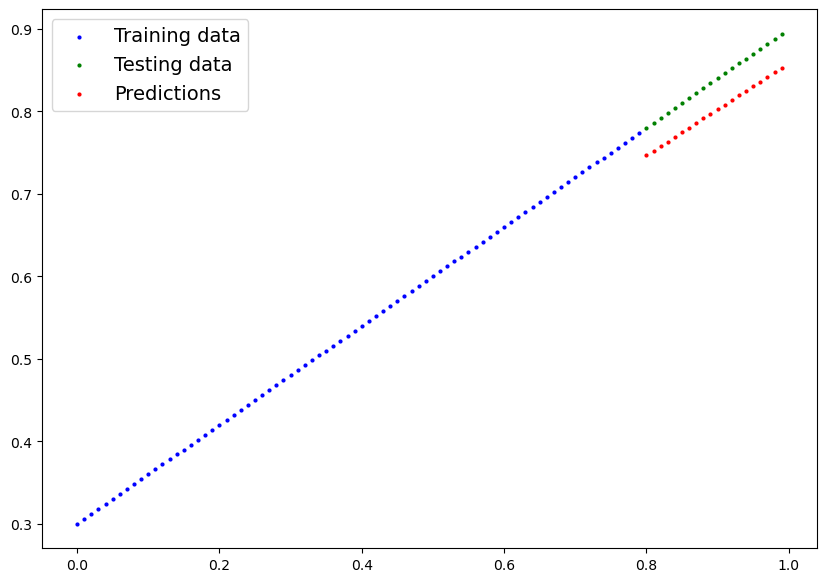

In [31]:
# Turn on evaluation mode
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(
    train_data=X_train_regression.cpu(), 
    train_labels=y_train_regression.cpu(), 
    test_data=X_test_regression.cpu(), 
    test_labels=y_test_regression.cpu(),
    predictions=y_preds.cpu())

The model is able to do better than random guessing on straight lines.

It means our model atleast has some capacity to learn.

**Note**: A helpful trouble shooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple NN and a small dataset and then **overfitting** (making the model perform too well) on that small example before increase the amount of data or the model size/design to reduce over fitting.

#### 6. The missing piece: non-linearity

##### 6.1 Recreating non-linear data (red and blue circles)
First create a data to start off fresh.

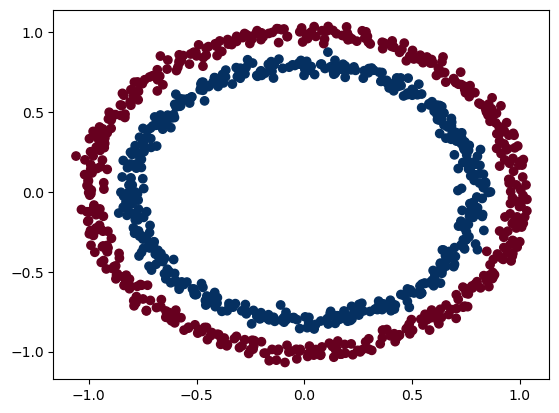

In [32]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [33]:
# convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.float).to(device)

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train[:5], y_train[:5], len(X_train), len(y_train)

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.], device='cuda:0'),
 800,
 800)

##### 6.2 Building a model with non-linearity

PyTorch has a bunch of ready-made non-linear activation functions that do similar but different things.
One of the most common and best performing is Relu (rectified linear-unit. `torch.nn.ReLU()`).

In [34]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.relu(self.layer_1(x))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [35]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

##### 6.3 Training a model with non-linearity

In [36]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    # Set Training mode
    model_3.train()

    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss and acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Set Testing/Eval Mode
    model_3.eval()
    with torch.inference_mode():
        # Forward pass
        y_logits_eval = model_3(X_test).squeeze()
        y_pred_eval = torch.round(torch.sigmoid(y_logits_eval))

        # Calculate loss and accuracy
        loss_eval = loss_fn(y_logits_eval, y_test)
        acc_eval = accuracy_fn(y_true=y_test, y_pred=y_pred_eval)
    
    # Model Log
    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Training Loss: {loss} | Training Accuracy: {acc} | Testing Loss: {loss_eval} | Testing Accuracy: {acc_eval}')

Epoch 0 | Training Loss: 0.6944103837013245 | Training Accuracy: 0.5 | Testing Loss: 0.6941157579421997 | Testing Accuracy: 0.5


Epoch 100 | Training Loss: 0.6898427605628967 | Training Accuracy: 0.52375 | Testing Loss: 0.6893523335456848 | Testing Accuracy: 0.51
Epoch 200 | Training Loss: 0.6870684623718262 | Training Accuracy: 0.5825 | Testing Loss: 0.6860122680664062 | Testing Accuracy: 0.59
Epoch 300 | Training Loss: 0.683375358581543 | Training Accuracy: 0.53875 | Testing Loss: 0.6817671656608582 | Testing Accuracy: 0.58
Epoch 400 | Training Loss: 0.6782612204551697 | Training Accuracy: 0.53875 | Testing Loss: 0.675914466381073 | Testing Accuracy: 0.57
Epoch 500 | Training Loss: 0.6705799698829651 | Training Accuracy: 0.5325 | Testing Loss: 0.6675345301628113 | Testing Accuracy: 0.58
Epoch 600 | Training Loss: 0.6582773923873901 | Training Accuracy: 0.59125 | Testing Loss: 0.654657244682312 | Testing Accuracy: 0.59
Epoch 700 | Training Loss: 0.6351744532585144 | Training Accuracy: 0.7175 | Testing Loss: 0.6326192021369934 | Testing Accuracy: 0.75
Epoch 800 | Training Loss: 0.5902673006057739 | Training Accu

In [37]:
# Make Predictions
model_3.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y[:10]

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 1.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.], device='cuda:0'))

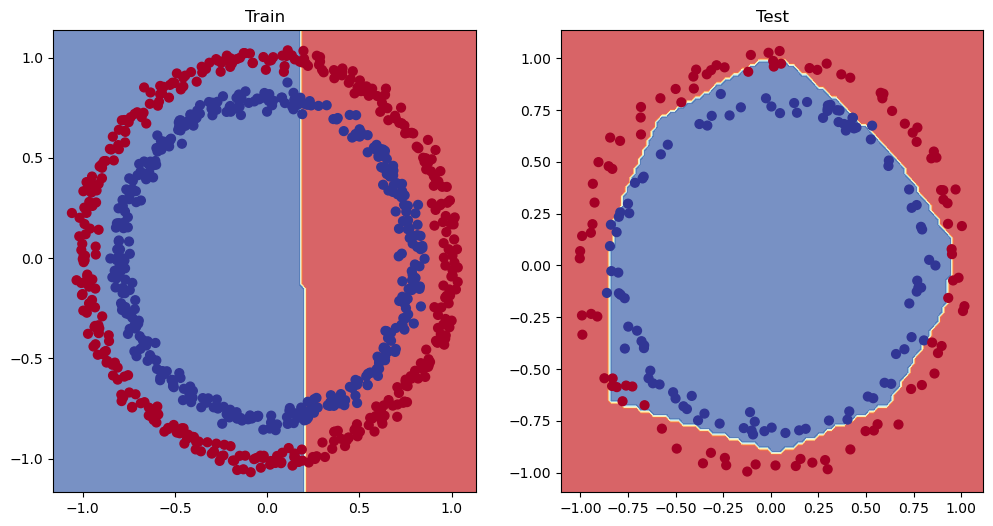

In [38]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

#### 7. Replicating non-linear activation functions

**Note**: Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes.

How about we replicate some and what they do?

Let's start by creating a small amount of data.

In [39]:
# Create a toy tensor (similar to the data going into our model(s))

A = torch.arange(-10, 10, 1, dtype=torch.float32, device=device)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.], device='cuda:0')

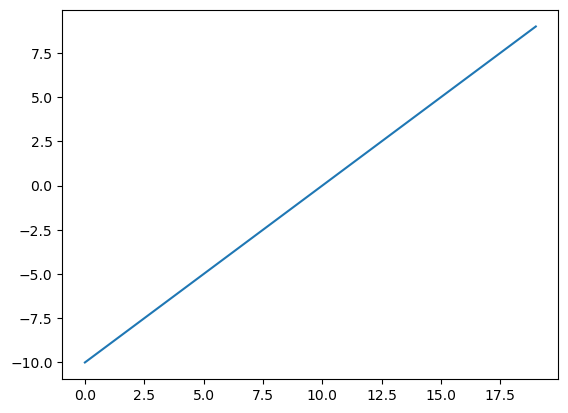

In [40]:
# Plot the toy tensor
plt.plot(A.cpu())

A staright line. Now let's see how the RLU activation function influences it. Instead of using PyTorch's ReLU (`torch.nn.ReLU`). The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [41]:
# Create ReLU function by hand
def relu(x: torch.Tensor()):
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.], device='cuda:0')

It looks like our ReLU function worked, all of the negatives values are zeros.

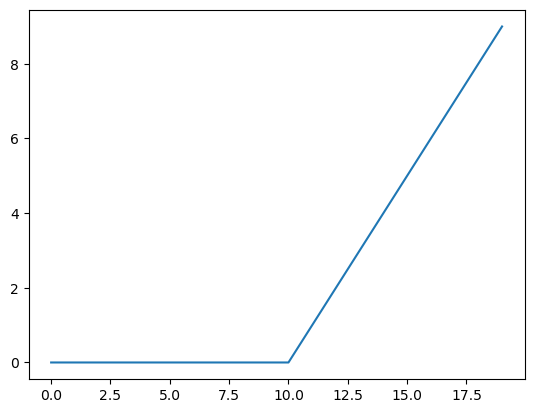

In [42]:
# Plot ReLU activated toy tensor
plt.plot(relu(A.cpu()))

How about we try the sigmoid function we've been using?

In [43]:
#C Create a custom sigmoid function
def sigmoid(x):
    return 1 /(1 + torch.exp(-x))

# Test custom sigmoid on toy tnesor
sigmoid(A.cpu())

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

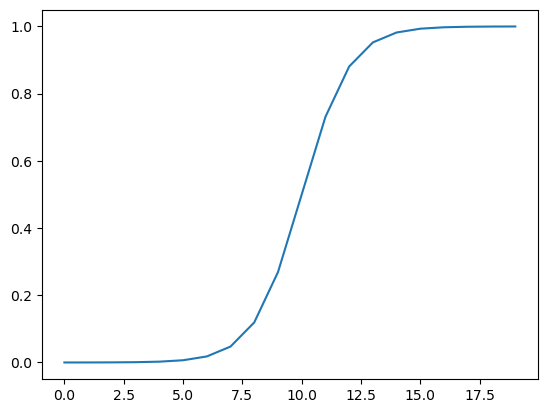

In [44]:
# PLot sigmoid activated toy tensor
plt.plot(sigmoid(A.cpu()))

now there are pleny more non-linear activation functions that exist in PyTorch that we haven't tried. But these two of the most commonr. The point, what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines?

Almost anything right?

#### 8. Putting things together by building a multi-class PyTorch model

Now let's put it all together using a multi-class classification problem

Recall a **binary classification** problem deals with classifying something as one of two options where as **multi-class classification** problem deals with classifying something from a list of more than two options.

![image](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-binary-vs-multi-class-classification.png)
Example of binary vs. multi-class classification

##### 8.1 Creating multi-class classification data

To begin, let's create some multi-class data.

To do so, we can leverage Scikit `make_blobs()` method.

This method will create however many classes (using the `centers` parameter) we want.

Specifically, we do the following:
1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors.
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3., 2., 2., 1., 1.])


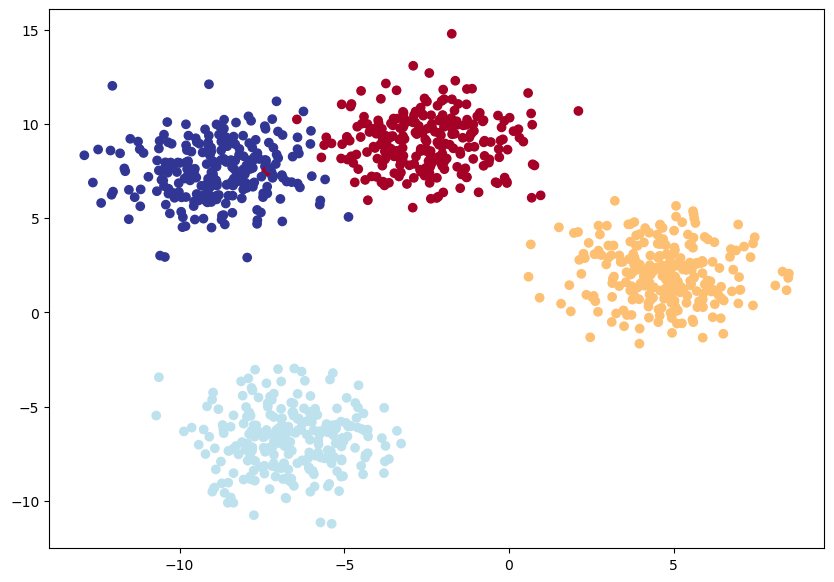

In [45]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000, # no. of samples
    n_features=NUM_FEATURES, # x features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # adds randomness
    random_state=RANDOM_SEED
)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)
print(X_blob[:5], y_blob[:5])

# Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

##### 8.2 Building a multi-class classification model in PyTorch

We will be building a similar `model_3` but this still capable of handling multi-class data?

To do so, let's create a sublcass of `nn.Module` that takes in three hyperparameters:
* `input_features` - the number of `X` features coming into the model.
* `output_features` - the ideal numbers of output features we'd like (this will be equivalent to `NUM_CLASSES` or the number of hidden neurons we'd like each hidden layer to use.)
* `hidden_units` - the number of hidden neurons we'd like to each hidden layer to use.

Since we're putting things together , let's setup some advice agnostic code

Then we'll create the model class using hyperparameters

In [46]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [47]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES,
    hidden_units=8
).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

##### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

Since we're working with multi-class classification problem, we'll use then `nn.CrossEntropyLoss()` method as our loss function.

We will stick using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.

In [48]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [49]:
# Perform a single forward pass on the data
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

#### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [50]:
# Perform a single forward pass on the data
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [51]:
# How many elements in a single predictions
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES,

(torch.Size([4]), 4)

In [52]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


Based on the prediction probabilities it is still jumbled numbers since our model hasnt been trained propery.

After pasing the logits through the softmax function, each indvidiual sample now ass to 1 (or very cose to).

In [53]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

Since there's one value for each class in `y_pred_probs`, the index of the highest value is the class the model thinks the specific data sample most belongs to

We can check which index has the highest value using `torch.argmax()`

In [54]:
# Which clas does the model think is the *most* likely  at the index 0 sample 
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


To summeriaxe, a model's raw output is referred to as **logits**.

For a multi-class classification problem, to turn the logits into **prediction probabilities**, you use the softmax activation function (**torch.softmax**).

The index of the value with the highest **prediction probability** is the class number the model thinks is most likely given the input features for that sample

##### 8.5 Create a training and testing loop for a multi-class PyTorch Model

We will start writing the training and testing loop to improve and evaluate our model.

The only difference is that we'll be adjusting the step to turn the model outputs (logits) to prediction probabilities (using softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation).

In [55]:
# Fit the model
torch.manual_seed(42)

# Set epoch
epochs = 100

# Set data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # Set model to training mode
    model_4.train()

    # Forward pass
    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_blob_train.type(torch.long))
    acc = accuracy_fn(y_true=y_blob_train,y_pred=y_preds)

    # OPptimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Set model to eval/training mode.
    model_4.eval()
    with torch.inference_mode():
        # Forward pass
        y_logits_eval = model_4(X_blob_test)
        y_preds_eval = torch.softmax(y_logits_eval, dim=1).argmax(dim=1)

        # Calcuate loss/accuracy
        loss_eval = loss_fn(y_logits_eval, y_blob_test.type(torch.long))
        acc_eval = accuracy_fn(y_true=y_blob_test, y_pred=y_preds_eval)
    
    # Model log
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Training Loss: {loss} | Training Accuracy: {acc} | Testing Loss: {loss_eval} | Testing Accuracy {acc_eval}')

    

Epoch: 0 | Training Loss: 1.0432369709014893 | Training Accuracy: 0.655 | Testing Loss: 0.5786146521568298 | Testing Accuracy 0.955
Epoch: 10 | Training Loss: 0.14397814869880676 | Training Accuracy: 0.99125 | Testing Loss: 0.13037431240081787 | Testing Accuracy 0.99
Epoch: 20 | Training Loss: 0.08061711490154266 | Training Accuracy: 0.99125 | Testing Loss: 0.07216108590364456 | Testing Accuracy 0.995
Epoch: 30 | Training Loss: 0.059235941618680954 | Training Accuracy: 0.99125 | Testing Loss: 0.051332827657461166 | Testing Accuracy 0.995
Epoch: 40 | Training Loss: 0.0489191859960556 | Training Accuracy: 0.99 | Testing Loss: 0.04098135605454445 | Testing Accuracy 0.995
Epoch: 50 | Training Loss: 0.04294963181018829 | Training Accuracy: 0.99 | Testing Loss: 0.03486066684126854 | Testing Accuracy 0.995
Epoch: 60 | Training Loss: 0.03909869119524956 | Training Accuracy: 0.99 | Testing Loss: 0.03083428554236889 | Testing Accuracy 0.995
Epoch: 70 | Training Loss: 0.03642876446247101 | Traini

##### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [56]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

**Note**: It's possible to skip the `torch.softmax()` function  and go straight by calling `torch.argmax()` directly on the logits

In [57]:
# Turn predicted logits into prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f'Prediction: {y_preds[:10]}\nLabels: {y_blob_test[:10]}')
print(f'Test Accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}')

Prediction: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.], device='cuda:0')
Test Accuracy: 0.995


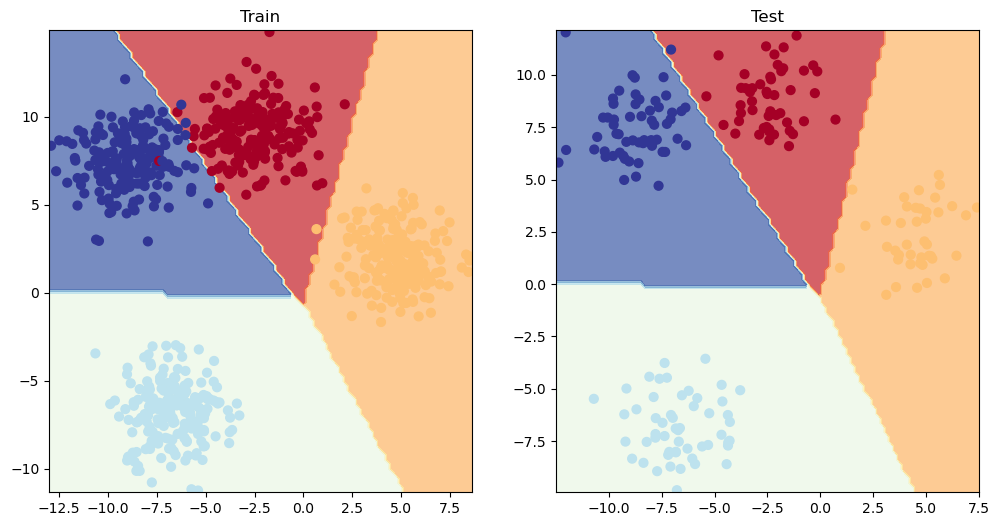

In [58]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

#### 9. More classification evaluation metrics

There are some of the most common methods you'll come across and are a good starting point. However, you may want to evaluate your classification model using more metrics such as the following:
| **Metric name/Evaluation method** | **Definition** | **Code** |
| --- | --- | --- |
| Accuracy | The amount the model got right | `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()` |
| Precision | Proportion of true positives over total no. of samples. Higher precision  leads to less false positive | `torchmetrics.Precision()` or `sklearn.metrics.precision_score()` |
| Recall | Proportion of true positive over total number of true positives and false negatives | `torcmetrics.Recall()` or `sklearn.metrics.recall_score()` |
| F1-score | Combines precision and reall into one metric. 1 is best, 0 is worst | `torchmetrics.F1Score()` or `sklearn.metrics.f1_score()` |
| Confusion matrix | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in teh matrix will be top left to bottom right (diagonal line). | `torchmetrics.ConfusionMatrix` or `sklearn.metrics.plot_confusion_matrix()` |
| Classification report | Collection of some of the main classification metrics such as precision, recall, and f1-score | `sklearn.metrics.classification_report()` |

Scikit-Learn has many implementations of the above metrics and you're looking for a PyTorch-like version, check out TorchMetrics, especially TorchMetrics classification section.

In [61]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')